# Mejorar una imagen de baja resolución / borrar marcas de agua

Las ideas contenidas aquí fueron presentadas por Jeremy Howard y el equipo de fast.ai en su [curso](https://course.fast.ai/).

En este notebook usaremos las imágenes que creamos en el notebook de "crappify". También, en la segunda parte del notebook usaremos un archivo de python llamado "PerceptualLoss".

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.vision as fv
from pathlib import Path
from shutil import copyfile
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as utils
import PIL
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm_notebook as tqdm
import gc
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path_good   = Path("imgnetsample")
path_crappy = Path("imgnetcrappy")

In [4]:
def imagen_bonita(x): 
    return path_good/x.relative_to(path_crappy)

def load_data(img_size, batch_size, amount=1.):
    data = (fv.ImageImageList.from_folder(path_crappy)
            .filter_by_rand(amount)
            .split_by_folder()
            .label_from_func(imagen_bonita)
            .transform(fv.get_transforms(max_zoom=1.1,max_warp=0.1), size=img_size, tfm_y=True)
            .databunch(bs=batch_size)
            .normalize(fv.imagenet_stats, do_y=True))
    data.c = 3
    return data

In [6]:
def l1_loss_flat(a,b):
    return F.l1_loss(a.squeeze(), b.squeeze())

In [7]:
def create_learner(data):
    return fv.unet_learner(data, fv.models.resnet34, 
                           blur=True, norm_type=fai.NormType.Weight, 
                           self_attention=True, y_range=(-3.,3.), 
                           loss_func=l1_loss_flat, wd=1e-2)


**Nota**: Cambia lo siguiente! Dependiendo del tamaño de tu dataset, etc y tamaño pequeño de imágenes.

In [8]:
data = load_data(128, 12, 0.1)
learn = create_learner(data)

Antes de entrenar, obtenemos ruido!

In [ ]:
learn.show_results(3) #

Parga guardar y cargar fácil el modelo

In [9]:
iteration = 'A'
def save_model(img_size, suffix=""):
    path = Path(f'imgnetsample/models/{iteration}')
    path.mkdir(exist_ok=True)
    torch.save(learn.model.state_dict(), path/f'{img_size}-{suffix}.pth')
def load_model(img_size, suffix=""):
    learn.model.load_state_dict(torch.load(f'imgnetsample/models/{iteration}/{img_size}-{suffix}.pth'))

In [19]:
#load_model(384,'perceptual-4')

In [15]:
def show_tensor_as_image(tensor, ncols=5, figsize=12, title = ""):
    plt.figure(figsize=(figsize,figsize))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(utils.make_grid(tensor.detach().cpu()[:ncols*ncols], nrow=ncols, padding=2, normalize=True).cpu(),(1,2,0)))

def compare_manually():
    data = load_data(384,4,amount=0.01)
    gc.collect()
    imgs,targs = next(iter(data.valid_dl))
    learn.model.eval();
    gen_imgs = learn.model(imgs)
    show_tensor_as_image(imgs, ncols=1)
    show_tensor_as_image(gen_imgs, ncols=1)
    show_tensor_as_image(targs, ncols=1)

Nota: Esto lo obtuvimos después de entrenar un montón (y cargar el modelo pre-entrenado)

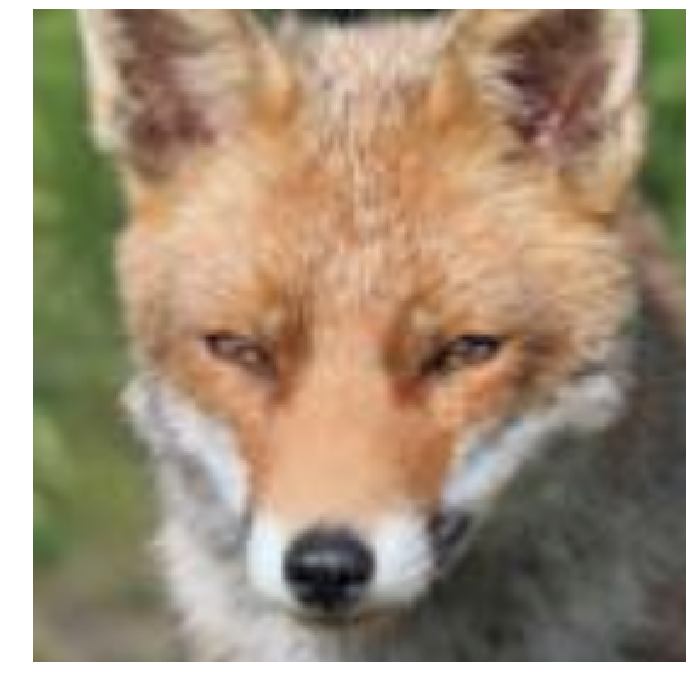

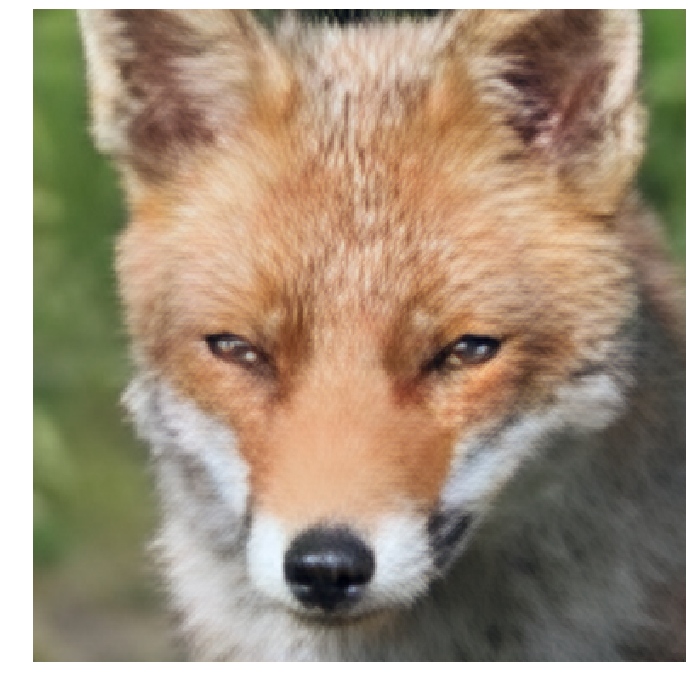

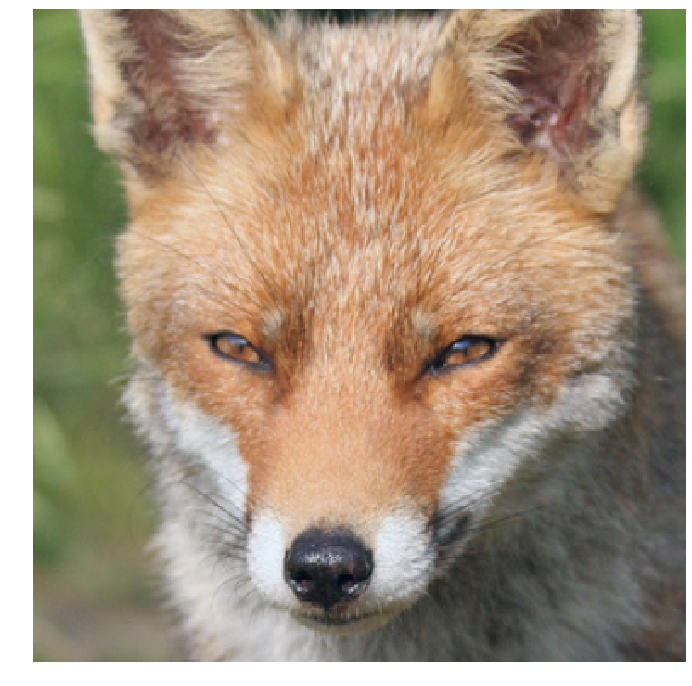

In [23]:
compare_manually()

# Parte de entrenamiento

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
gc.collect()

In [ ]:
#learn.fit_one_cycle(1,1e-3) # bla bla bla

In [17]:
#load_model(320, 'perceptual-4')

Quizás quieras entrenar bastante menos que lo que dice aquí, y con diferentes batch_sizes, dependiendo de tu memoria de GPU.

In [ ]:
sizes = [192, 224, 256, 288, 320]
AS = {192:0.02, 224: 0.04, 256:0.06, 288:0.08, 320:0.1}
BS = {192:24, 224: 16, 256:12, 288:8, 320:4}

for size in sizes:
    lr = 2e-4
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr))
        save_model(size,freeze) 
        lr *= 0.8

Los tuyos no se verán bonitos así. Se verán borrositos. Eso está bien. Después ya se verán bonitos.

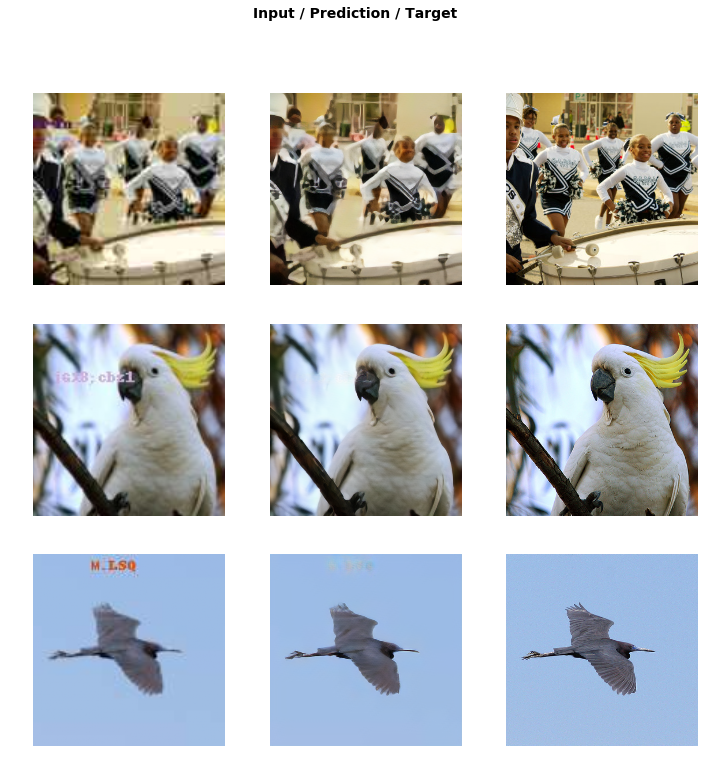

In [18]:
learn.show_results(rows=4)

# Perceptual loss

Aquí tenemos que crear un archivo de python con el contenido del notebook "PerceptualLoss".

In [ ]:
from PerceptualLoss import PerceptualLoss

In [ ]:
learn.loss_func = ps.PerceptualLoss()

In [ ]:
learn.data = load_data(384,4,0.001)

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
sizes = [224, 256, 288, 320, 384]
AS = {192:0.04, 224: 0.06, 256:0.08, 288:0.1, 320:0.2, 384:0.4}
BS = {192:24, 224:12, 256:8, 288:6, 320:4, 384:4}

for size in sizes:
    lr = 1e-3
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr))
        save_model(size,f'perceptual-{freeze+1}') 
        lr *= 0.8

In [ ]:
learn.show_results(rows=4,figsize=(18,18))

In [ ]:
learn.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
compare_manually()

In [ ]:
learn.lr_find(); learn.recorder.plot()

In [ ]:
num_cycles = 3
for cycle in range(num_cycles):
    gc.collect()
    learn.data = load_data(384,4,0.333)
    learn.fit_one_cycle(1,slice(2e-6,1e-4),pct_start=0.8)
    save_model(384,f'shippuden-{cycle}')

### Idea: ¿podemos pasar dos o más veces una imagen por la red?